In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import time
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
import xgboost as xgb
import psycopg2 ##pip install psycopg2-binary
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from scipy.special import gammaln
from elasticsearch import Elasticsearch, helpers

from api.setup_aws import S3Manager
from api.setup_aws import DBManager
from api.setup_aws import EC2Manager

retraining_cycle = 3600 #in seconds, after each hour, new training run
retraining_frame = int(time.time() - retraining_cycle) * 1000  
es_index = "customer_records_db"
model_registry_name = "models_in_production"

In [ ]:
artifact_name = S3Manager.generate_bucket_name()
S3Manager.create_bucket(artifact_name)

dbcreator = DBManager()
dbcreator.create_postgredb()
backend_store = dbcreator.get_db_endpoint()

# backend_store = ""
# artifact_name = ""

MLFLOW_SERVER_HOST, ES_SERVER_HOST = EC2Manager.create_instance(backend_store, artifact_name)

# MLFLOW_SERVER_HOST = ""
# ES_SERVER_HOST = ""

#mlflow tracking server hosted on AWS EC2
mlflow.set_tracking_uri(f"http://{MLFLOW_SERVER_HOST}:5000")
mlflow.set_experiment("project-experiment")
mlflow_client = MlflowClient(tracking_uri=backend_store)

#elastic search server hosted on same AWS EC2 instance
es = Elasticsearch(f"http://{ES_SERVER_HOST}:9200")
es

In [2]:
#read from snowflake not in local
df = pd.read_csv('dataset/data.csv', delimiter=';')

/tmp/ipykernel_987079/3197900106.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset/data.csv', delimiter=';')


In [3]:
df.dtypes

ID                        int64
Date_start_contract      object
Date_last_renewal        object
Date_next_renewal        object
Date_birth               object
Date_driving_licence     object
Distribution_channel     object
Seniority                 int64
Policies_in_force         int64
Max_policies              int64
Max_products              int64
Lapse                     int64
Date_lapse               object
Payment                   int64
Premium                 float64
Cost_claims_year        float64
N_claims_year             int64
N_claims_history          int64
R_Claims_history        float64
Type_risk                 int64
Area                      int64
Second_driver             int64
Year_matriculation        int64
Power                     int64
Cylinder_capacity         int64
Value_vehicle           float64
N_doors                   int64
Type_fuel                object
Length                  float64
Weight                    int64
dtype: object

In [4]:
dropped_columns = ['Date_start_contract', 'Date_last_renewal', 'Date_next_renewal', 'Lapse', 
                   'Date_lapse', 'Max_products','Distribution_channel', 'Policies_in_force', 
                   'N_claims_history', 'Cost_claims_year', 'N_claims_year', 'Max_policies',
                   'Payment', 'Date_birth', 'Date_driving_licence', 'Year_matriculation', 'N_doors', 'Length', 'Weight', 'Seniority', 'customer_year']

streamed_columns = ['Date_birth', 'Date_driving_licence', 'Type_risk', 'Area', 'Second_driver', 'Power', 
                    'Cylinder_capacity', 'Value_vehicle', 'Type_fuel', 'Year_matriculation']

es_columns = ['ID', 'Date_birth', 'Date_driving_licence', 'av_senior_year', 'R_Claims_history', 'policy_stability', 'product_stability', 'claims_per_policy', 'cost_per_claim']

categorical = ['Type_risk', 'Type_fuel']

target = 'Premium'
unique_id = 'ID'

In [5]:
def df_preprocess(df: pd.DataFrame):
    ## data preprocessing for training
    df['Date_start_contract'] = pd.to_datetime(df['Date_start_contract'], format='%d/%m/%Y')
    df['Date_last_renewal'] = pd.to_datetime(df['Date_last_renewal'], format='%d/%m/%Y')
    df['Date_birth'] = pd.to_datetime(df['Date_birth'], format='%d/%m/%Y')
    df['Date_driving_licence'] = pd.to_datetime(df['Date_driving_licence'], format='%d/%m/%Y')
    
    ## feature engineering
    df['customer_year'] = ((df['Date_last_renewal'] - df['Date_start_contract']).dt.days / 365).round(2)
    df['av_senior_year'] = (((df['Seniority']**(2/3)) + (df['customer_year']**2)) / 2).round(2)
    df['customer_age'] = ((df['Date_last_renewal'] - df['Date_birth']).dt.days / 365).round(2)
    df['driving_licence_long'] = ((df['Date_last_renewal'] - df['Date_driving_licence']).dt.days / 365).round(2)
    df['vehicle_age'] = (df['Date_last_renewal'].dt.year - df['Year_matriculation'])
    
    df['policy_stability'] = df['Policies_in_force'] / df['Max_policies']
    df['product_stability'] = df['Policies_in_force'] / df['Max_products']
    df['claims_per_policy'] = df['N_claims_history'] / df['Max_policies']
    df['cost_per_claim'] = np.where(df['N_claims_year'] == 0, 0, df['Cost_claims_year'] / df['N_claims_year'])
    
    df_ = df.copy()

    for column in dropped_columns:
        df = df.drop(column, axis=1)

    df = df.drop(unique_id, axis=1)
    df[categorical] = df[categorical].astype(str)

    return df, df_

In [6]:
#######test data will be added
def train_val_split(df: pd.DataFrame):
    premiums = df[target]
    df = df.drop(target, axis=1)
    
    x_train, x_val, y_train, y_val = train_test_split(df, premiums, test_size=0.25, random_state=42)

    return x_train, x_val, y_train, y_val

In [7]:
def prepare_dicts(X:pd.DataFrame):
    dicts = X.to_dict(orient='records')
    
    return dicts

In [13]:
def prepare_elastic_db(df: pd.DataFrame, es_index):
    
    df_es = df[es_columns]
    df_es = df_es.groupby(unique_id).last().reset_index()

    index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "ID": {"type": "keyword"} 
        }
    }
    }

    def dataframe_to_es(df, es_index):
        for df_idx, line in df.iterrows():
            yield {
                "_index": es_index,
                "_id":df_idx,
                "_source" : {
                    "ID": line.iloc[0],
                    "Date_birth": line.iloc[1],
                    "Date_driving_licence": line.iloc[2],
                    "av_senior_year": line.iloc[3],
                    "R_Claims_history": line.iloc[4],
                    "policy_stability": line.iloc[5],
                    "product_stability": line.iloc[6],
                    "claims_per_policy": line.iloc[7],
                    "cost_per_claim": line.iloc[8]
                }
            }
        
    helpers.bulk(es, dataframe_to_es(df_es, es_index), raise_on_error=False)

    return df_es

In [9]:
##utility function
def gamma_negative_log_likelihood(y_true, y_pred):
    # y_pred are the predicted rates (inverse scale parameter)
    shape = 2.0  # Assumed shape parameter for simplicity; this can also be learned
    rate = y_pred  # Rate parameter (predicted)
    log_likelihood = shape * np.log(rate) + (shape - 1) * np.log(y_true) - rate * y_true - gammaln(shape)
    return -np.mean(log_likelihood)

In [14]:
df, df_ = df_preprocess(df)
x_train, x_val, y_train, y_val = train_val_split(df)
dict_train = prepare_dicts(x_train)
dict_val = prepare_dicts(x_val)
df_es = prepare_elastic_db(df_, es_index)

In [15]:
df

,Premium,R_Claims_history,Type_risk,Area,Second_driver,Power,Cylinder_capacity,Value_vehicle,Type_fuel,av_senior_year,customer_age,driving_licence_long,vehicle_age,policy_stability,product_stability,claims_per_policy,cost_per_claim
0,222.52,0.0,1,0,0,80,599,7068.00,P,1.26,59.60,39.65,11,0.5,1.0,0.0,0.0
1,213.78,0.0,1,0,0,80,599,7068.00,P,1.76,60.60,40.66,12,0.5,1.0,0.0,0.0
2,214.84,0.0,1,0,0,80,599,7068.00,P,3.26,61.60,41.66,13,1.0,2.0,0.0,0.0
3,216.99,0.0,1,0,0,80,599,7068.00,P,5.76,62.60,42.66,14,1.0,2.0,0.0,0.0
4,213.70,0.0,1,0,0,80,599,7068.00,P,1.26,61.49,41.55,13,1.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105550,263.79,0.0,3,0,0,110,1997,24320.00,D,0.50,37.04,11.46,18,1.0,1.0,0.0,0.0
105551,418.97,0.0,3,0,0,129,1998,30861.97,P,0.50,41.72,0.71,5,1.0,1.0,0.0,0.0
105552,571.91,0.0,3,0,0,55,999,7800.00,P,0.50,44.67,7.13,19,1.0,1.0,0.0,0.0
105553,339.66,0.0,2,0,0,90,1753,16610.00,D,0.50,72.23,36.82,14,1.0,1.0,0.0,0.0


In [17]:
df_es

,ID,Date_birth,Date_driving_licence,av_senior_year,R_Claims_history,policy_stability,product_stability,claims_per_policy,cost_per_claim
0,1,1956-04-15,1976-03-20,5.76,0.0,1.0,2.0,0.0,0.0
1,2,1956-04-15,1976-03-20,1.76,0.0,1.0,2.0,0.0,0.0
2,3,1975-03-18,1995-07-10,15.54,0.0,0.5,1.0,0.0,0.0
3,4,1973-07-10,1993-07-05,3.04,0.0,1.0,2.0,0.0,0.0
4,5,1973-07-10,1993-07-05,1.54,0.0,1.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
53497,53498,1981-07-25,2007-02-14,0.50,0.0,1.0,1.0,0.0,0.0
53498,53499,1976-12-08,2017-11-29,0.50,0.0,1.0,1.0,0.0,0.0
53499,53500,1974-04-01,2011-10-05,0.50,0.0,1.0,1.0,0.0,0.0
53500,53501,1946-09-15,1982-02-02,0.50,0.0,1.0,1.0,0.0,0.0


In [17]:
keyword = "4838"
res = es.search(index=es_index, body={
    "query": {
        "bool": {
            "should": [
                {
                    "match": {
                        "ID": keyword
                    }
                }
            ]
        }
    }
})

In [18]:
res['hits']['hits'][0]['_source']

{'ID': 4838,
 'Date_birth': '1976-03-13T00:00:00',
 'Date_driving_licence': '1994-05-13T00:00:00',
 'Seniority': 2,
 'R_Claims_history': 0.0,
 'policy_stability': 1.0,
 'product_stability': 1.0,
 'claims_per_policy': 0.0,
 'cost_per_claim': 0.0}

In [19]:
def hyperparameter_tuning(
    dict_train,
    dict_val,
    y_train: np.ndarray,
    y_val: np.ndarray,
) -> None:

    def objective(params):
        with mlflow.start_run():
            mlflow.set_tag("model", "xgboost")
            mlflow.log_params(params)

            vectorizer = DictVectorizer(sparse=False)
            X_train = vectorizer.fit_transform(dict_train)
            X_val = vectorizer.transform(dict_val)

            model = xgb.XGBRegressor(**params,
                                    n_estimators=200,
                                    early_stopping_rounds=50
            )

            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
            y_pred = model.predict(X_val)

            nll = gamma_negative_log_likelihood(y_val, y_pred)
            print(params, nll)
            mlflow.log_metric('gamma-nll', nll)

            # Log the vectorizer and model as a pipeline
            pipeline = make_pipeline(vectorizer, model)

            mlflow.sklearn.log_model(pipeline, artifact_path="model")     
    
        return {'loss': nll, 'status': STATUS_OK}

    search_space = {
        'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
        'learning_rate': hp.loguniform('learning_rate', -3, 0),
        'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
        'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
        'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
        'objective': 'reg:gamma',
        'seed': 42
    }

    best_result = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=10,
        trials=Trials()
    )

    return best_result

In [20]:
hyperparameter_tuning(dict_train,
    dict_val,
    y_train,
    y_val)

{'learning_rate': 0.6395822328667712, 'max_depth': 54, 'min_child_weight': 1.382752564257594, 'objective': 'reg:gamma', 'reg_alpha': 0.1905433566428214, 'reg_lambda': 0.012839123658872865, 'seed': 42}
107082.87676480896                                    
{'learning_rate': 0.08127545356951954, 'max_depth': 64, 'min_child_weight': 16.775406513236902, 'objective': 'reg:gamma', 'reg_alpha': 0.008234262534276914, 'reg_lambda': 0.0036537201229567434, 'seed': 42}
107104.6365823297                                                               
 10%|█         | 1/10 [01:12<04:57, 33.09s/trial, best loss: 107082.87676480896]

/home/mcaydin/anaconda3/envs/mlops-env/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/mcaydin/anaconda3/envs/mlops-env/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



{'learning_rate': 0.38534171796864536, 'max_depth': 96, 'min_child_weight': 2.7791020873081065, 'objective': 'reg:gamma', 'reg_alpha': 0.010522650354136149, 'reg_lambda': 0.05344607783852216, 'seed': 42}
107475.19318063866                                                              
{'learning_rate': 0.22924858490101765, 'max_depth': 78, 'min_child_weight': 2.1278763033420205, 'objective': 'reg:gamma', 'reg_alpha': 0.01893796371968336, 'reg_lambda': 0.041507437432952106, 'seed': 42}
107335.47627843992                                                              
{'learning_rate': 0.7382127897654177, 'max_depth': 94, 'min_child_weight': 4.529938241125059, 'objective': 'reg:gamma', 'reg_alpha': 0.36397748712864886, 'reg_lambda': 0.005176448148580353, 'seed': 42}
107953.86509110885                                                              
{'learning_rate': 0.17187754247057926, 'max_depth': 31, 'min_child_weight': 0.8020207040898191, 'objective': 'reg:gamma', 'reg_alpha': 0.0420872513

2024/07/12 14:46:33 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under s3://kprjmhheqk/1/098e2951ce8e482eae5b937bd3485dcd/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.



100%|██████████| 10/10 [12:00<00:00, 72.08s/trial, best loss: 105995.59435146989] 


{'learning_rate': 0.17187754247057926,
 'max_depth': 31.0,
 'min_child_weight': 0.8020207040898191,
 'reg_alpha': 0.042087251372571924,
 'reg_lambda': 0.22340900898893343}

In [21]:
##utility function
def get_best_model_uri():
    
    runs = mlflow_client.search_runs(
        experiment_ids='1',
        run_view_type=ViewType.ACTIVE_ONLY
    )

    # Filter runs that started within the retraining frame
    recent_runs = [run for run in runs if run.info.start_time >= retraining_frame]

    # Sort the filtered runs by the desired metric
    sorted_runs = sorted(recent_runs, key=lambda run: run.data.metrics.get('gamma-nll', float('inf')))

    if sorted_runs:
        best_run = sorted_runs[0]
        best_model_uri = best_run.info.artifact_uri
        return best_model_uri
    else:
        return None

In [22]:
##utility function
def get_test_result(model_uri):
    
    logged_model = f"""{model_uri}/model"""
    loaded_model = mlflow.pyfunc.load_model(logged_model)

    #test data will be added
    y_pred = loaded_model.predict(dict_val)

    nll = gamma_negative_log_likelihood(y_val, y_pred)

    return nll

In [23]:
def tag_best_model():
    run_best_model_uri = get_best_model_uri()

    #New model performance
    new_model_performance = get_test_result(run_best_model_uri)

    try:
        production_models = mlflow_client.get_latest_versions(model_registry_name, stages=["Production"])
    except mlflow.exceptions.MlflowException:
        production_models = []

    try:
        staging_models = mlflow_client.get_latest_versions(model_registry_name, stages=["Staging"])
    except mlflow.exceptions.MlflowException:
        staging_models = []
    
    if not production_models and not staging_models:
        # Add initial run as in production stage
        new_version = mlflow.register_model(model_uri=run_best_model_uri, name=model_registry_name)
        mlflow_client.transition_model_version_stage(name=model_registry_name, version=new_version.version, stage="Production")
        current_production_model = mlflow_client.get_latest_versions(model_registry_name, stages=["Production"])
        
        return
    
    if production_models and not staging_models:
        current_production_model = production_models[0]
        current_production_uri = current_production_model.source
        #Current in production model performance
        current_production_performance = get_test_result(current_production_uri)
        
        # Performance comparison
        if new_model_performance < current_production_performance:
            # New model better, put production stage, current one into staging.
            print("New model better, put into production stage")
            new_version = mlflow.register_model(model_uri=run_best_model_uri, name=model_registry_name)
            mlflow_client.transition_model_version_stage(name=model_registry_name, version=current_production_model.version, stage="Staging")
            mlflow_client.transition_model_version_stage(name=model_registry_name, version=new_version.version, stage="Production")

        else:
            # New model worse, put staging stage
            print("New model worse, put into staging stage")
            new_version = mlflow.register_model(model_uri=run_best_model_uri, name=model_registry_name)
            mlflow_client.transition_model_version_stage(name=model_registry_name, version=new_version.version, stage="Staging")
        
        return
    
    if production_models and staging_models:
        current_production_model = production_models[0]
        current_production_uri = current_production_model.source
        #Current in production model performance
        current_production_performance = get_test_result(current_production_uri)
        
        current_staging_model = staging_models[0]
        current_staging_uri = current_staging_model.source
        #Current in staging model performance
        current_staging_performance = get_test_result(current_staging_uri)
        
        if new_model_performance < current_production_performance:
            # New model is the best amongst models in production and staging stage
            print("New model is the best, put into production stage")
            new_version = mlflow.register_model(model_uri=run_best_model_uri, name=model_registry_name)
            mlflow_client.transition_model_version_stage(name=model_registry_name, version=new_version.version, stage="Production")
            mlflow_client.transition_model_version_stage(name=model_registry_name, version=current_production_model.version, stage="Staging")
            mlflow_client.transition_model_version_stage(name=model_registry_name, version=current_staging_model.version, stage="None")
        elif new_model_performance < current_staging_performance:
            # New model is only better than model in staging
            print("New model is only better than current staging model, put into staging stage")
            new_version = mlflow.register_model(model_uri=run_best_model_uri, name=model_registry_name)
            mlflow_client.transition_model_version_stage(name=model_registry_name, version=new_version.version, stage="Staging")
            mlflow_client.transition_model_version_stage(name=model_registry_name, version=current_staging_model.version, stage="None")
        else:
            # New model is worst, put into none stage
            print("New model is the worst, to none stage")
            new_version = mlflow.register_model(model_uri=run_best_model_uri, name=model_registry_name)
            mlflow_client.transition_model_version_stage(name=model_registry_name, version=new_version.version, stage="None")
        return
    

    

In [24]:
tag_best_model()

WARNI [urllib3.connectionpool] Connection pool is full, discarding connection: s3.eu-west-2.amazonaws.com. Connection pool size: 10
WARNI [urllib3.connectionpool] Connection pool is full, discarding connection: s3.eu-west-2.amazonaws.com. Connection pool size: 10
WARNI [urllib3.connectionpool] Connection pool is full, discarding connection: s3.eu-west-2.amazonaws.com. Connection pool size: 10
WARNI [urllib3.connectionpool] Connection pool is full, discarding connection: s3.eu-west-2.amazonaws.com. Connection pool size: 10
/tmp/ipykernel_363239/1888287277.py:8: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.1/model-registry.html#migrating-from-stages
  production_models = mlflow_client.get_latest_versions(model_registry_name, stages=["Production"])
/

In [27]:
current_production_model = mlflow_client.get_latest_versions(model_registry_name, stages=["Production"])
current_production_uri = current_production_model[0].source
current_production_performance = get_test_result(current_production_uri)

print(current_production_performance)

/tmp/ipykernel_363239/225093209.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.1/model-registry.html#migrating-from-stages
  current_production_model = mlflow_client.get_latest_versions(model_registry_name, stages=["Production"])


WARNI [urllib3.connectionpool] Connection pool is full, discarding connection: s3.eu-west-2.amazonaws.com. Connection pool size: 10
WARNI [urllib3.connectionpool] Connection pool is full, discarding connection: s3.eu-west-2.amazonaws.com. Connection pool size: 10
WARNI [urllib3.connectionpool] Connection pool is full, discarding connection: s3.eu-west-2.amazonaws.com. Connection pool size: 10
WARNI [urllib3.connectionpool] Connection pool is full, discarding connection: s3.eu-west-2.amazonaws.com. Connection pool size: 10


105995.59435146989


/tmp/ipykernel_81149/2265811519.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_81149/2265811519.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


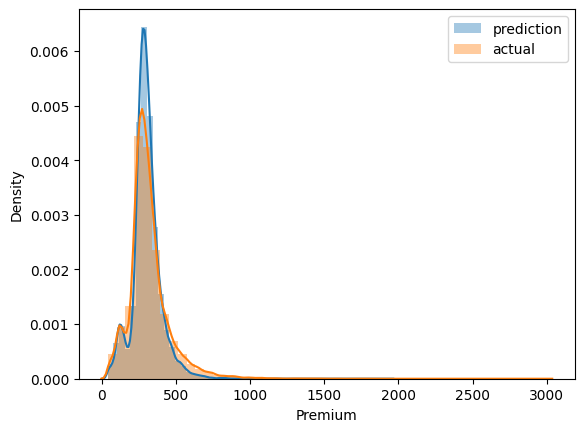

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()